In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import summary
from palmerpenguins import load_penguins
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (7, 4)

# Chapter 3

In [2]:
penguins = load_penguins()
penguins.dropna(how='any', axis=0, inplace=True)

In [3]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [4]:
adelie_mask = (penguins['species'] == 'Adelie')
adelie_mass_obs = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

### Code 3.3

In [5]:
def model_prior(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

In [6]:
#  prior predictive --> mu and sigma
samples = Predictive(
    model_prior, {}, num_samples=1000, 
    return_sites=['sigma', 'mu', 'mass'])(adelie_mass_obs)

In [7]:
samples['mass'].unsqueeze(-1).flatten().numpy()

array([3750., 3800., 3250., ..., 3750., 3700., 4000.])

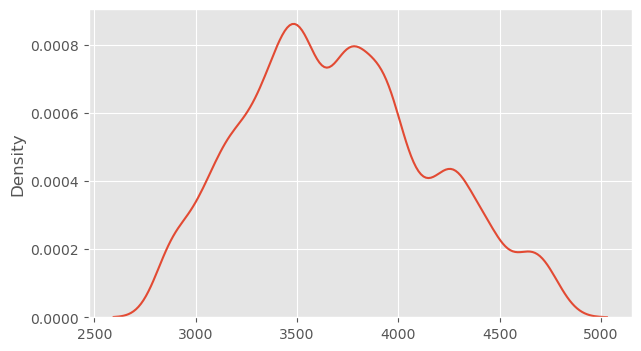

In [8]:
sns.kdeplot(samples['mass'].unsqueeze(-1).flatten().numpy(), bw_adjust=2);
# or
#az.plot_density(data=samples['mass'].numpy());

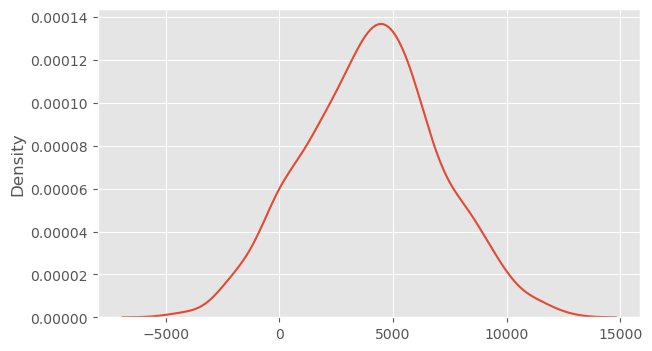

In [9]:
sns.kdeplot(samples['mu'].unsqueeze(-1).flatten().numpy(), bw_adjust=1);

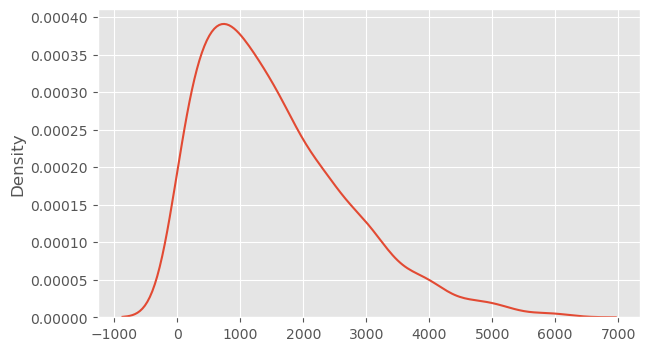

In [10]:
sns.kdeplot(samples['sigma'].unsqueeze(-1).flatten().numpy(), bw_adjust=1);

In [11]:
def model(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

    return mass

In [12]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=500, warmup_steps=300)
mcmc.run(obs=adelie_mass_obs)
mcmc.summary()

Sample: 100%|██████████| 800/800 [00:11, 67.22it/s, step size=1.01e+00, acc. prob=0.920] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu   3703.54     36.73   3701.85   3644.87   3762.89    383.20      1.00
     sigma    461.38     26.73    458.83    423.39    507.44    376.69      1.00

Number of divergences: 0


## 3.2.1 Linear Penguins

In [5]:
adelie_flipper_length = torch.from_numpy(penguins.loc[adelie_mask, 'flipper_length_mm'].values)
adelie_flipper_length -= adelie_flipper_length.mean()
adelie_mass = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

In [14]:
def linear_model(flipper_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 4000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 4000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

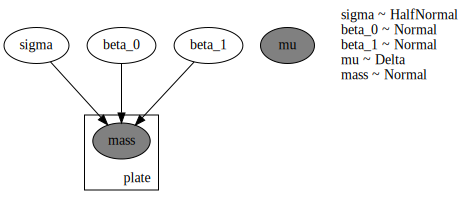

In [15]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, adelie_mass),
    render_distributions=True
    )

### MCMC

In [16]:
kernel = NUTS(linear_model, adapt_step_size=True)
mcmc_simple = MCMC(kernel, num_samples=500, warmup_steps=300)
mcmc_simple.run(flipper_length=adelie_flipper_length, mass=adelie_mass)

Sample: 100%|██████████| 800/800 [00:37, 21.16it/s, step size=9.30e-01, acc. prob=0.911] 


In [17]:
mcmc_simple.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0   3706.50     33.96   3706.28   3650.73   3755.13    421.93      1.01
    beta_1     32.37      5.06     32.27     25.29     42.32    401.68      1.00
     sigma    408.44     23.59    407.82    366.63    443.52    353.65      1.00

Number of divergences: 0


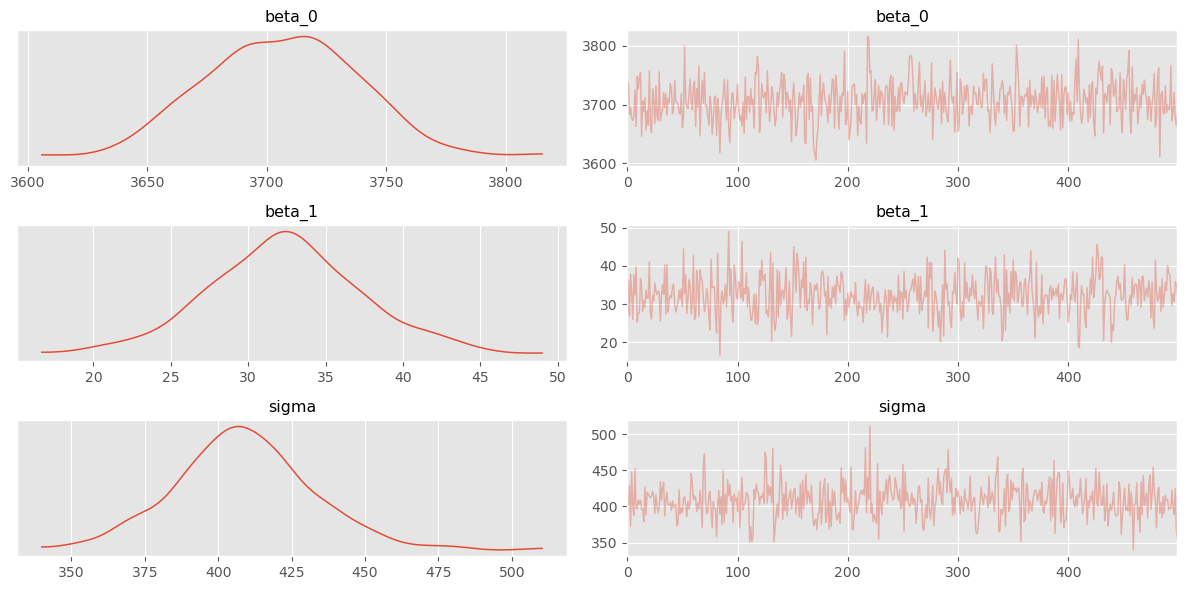

In [18]:
# trace plots are interesting for only only chain
az.plot_trace(az.from_pyro(mcmc_simple))
plt.tight_layout()

### Posterior Predictive Distribution

In [19]:
# posterior samples
mcmc_samples = mcmc_simple.get_samples(num_samples=1000)
# pred. dist. conditioned on posterior samples
predictive = Predictive(linear_model, mcmc_samples)
predictive_samples = predictive(flipper_length=adelie_flipper_length, mass=None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

mass: (1000, 146)
mu: (1000, 1, 146)


In [20]:
def mcmc_fit(predictive):
    mass = predictive['mass']
    mass_mu = mass.mean(axis=0)
    mass_std = mass.std(axis=0)

    mass_df = pd.DataFrame({
        'feat': adelie_flipper_length,
        'mean': mass_mu,
        'high': mass_mu + mass_std,
        'low': mass_mu - mass_std}
    )

    return mass_df.sort_values(by=['feat'])

In [21]:
mass_df = mcmc_fit(predictive=predictive_samples)

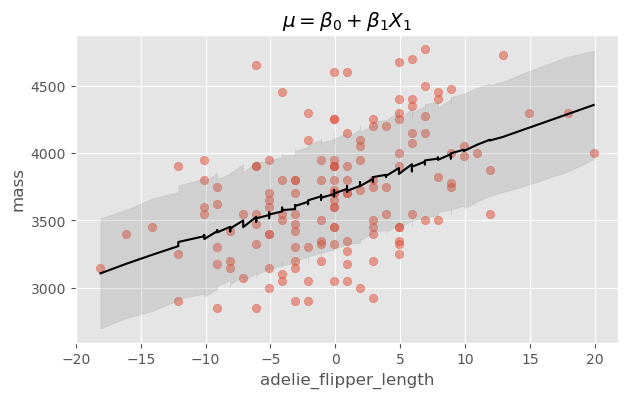

In [96]:
plt.scatter(adelie_flipper_length.numpy(), adelie_mass.numpy(), alpha=0.5)
plt.plot(mass_df['feat'], mass_df['mean'], color='black')
plt.fill_between(
    mass_df['feat'], mass_df['high'], mass_df['low'], alpha=0.2, color='grey')
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.title('$\mu =  \\beta_0 + \\beta_1X_1$')
plt.show()

### SVI

**NOT WORKING: I believe it has to do with the autoguide. Solution could be to implement the guide by hand**

pyro.get_param_store() is comprised of learned parameters that will be used in the `Predictive` stage. Instead of providing samples, the `guide` parameter is used to construct the posterior predictive distribution

## 3.3 Multiple Linear Regression

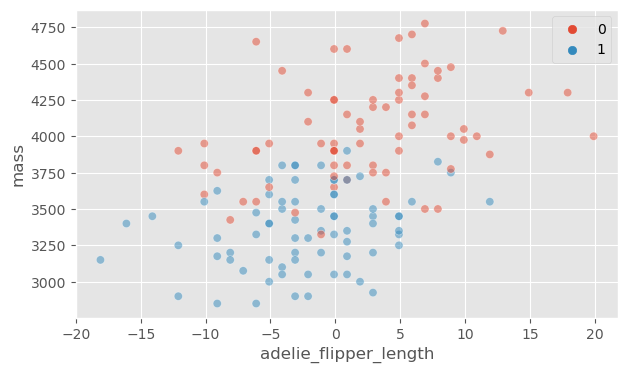

In [6]:
sex_obs = torch.from_numpy(penguins.loc[adelie_mask, 'sex'].replace({'male': 0, 'female': 1}).values)

sns.scatterplot(
    x=adelie_flipper_length, y=adelie_mass_obs, hue=sex_obs, alpha=0.5)
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.show()

In [24]:
def linear_model(flipper_length, sex, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 3000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 3000.))
    beta_2 = pyro.sample('beta_2', dist.Normal(0., 3000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length + beta_2 * sex)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

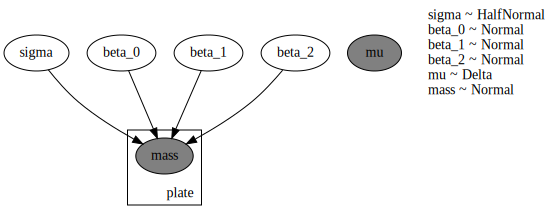

In [25]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, sex_obs, adelie_mass),
    render_distributions=True
    )

### MCMC

In [26]:
kernel = NUTS(linear_model, adapt_step_size=True)
mcmc = MCMC(kernel, num_samples=500, warmup_steps=300, num_chains=1)
mcmc.run(flipper_length=adelie_flipper_length, sex=sex_obs, mass=adelie_mass)
mcmc.summary()

Sample: 100%|██████████| 800/800 [00:53, 15.07it/s, step size=5.06e-01, acc. prob=0.926] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0   4004.68     37.17   4003.62   3947.60   4064.92    329.83      1.00
    beta_1     16.42      3.98     16.41      9.50     22.23    234.91      1.00
    beta_2   -597.92     54.41   -594.84   -684.72   -514.38    313.84      1.00
     sigma    297.48     18.46    296.21    271.08    332.22    352.02      1.00

Number of divergences: 0


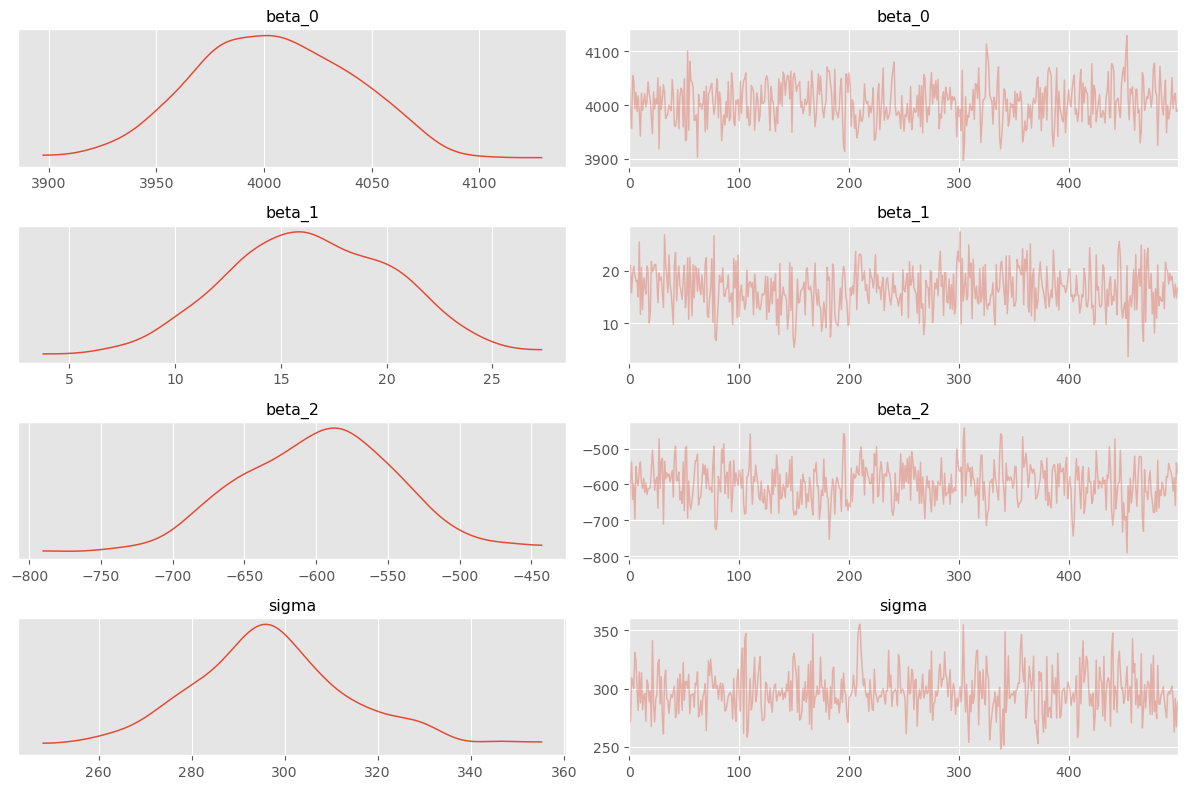

In [27]:
az.plot_trace(az.from_pyro(mcmc))
plt.tight_layout()

In [28]:
mcmc_samples = mcmc.get_samples(num_samples=1000)
predictive = Predictive(linear_model, mcmc_samples)
predictive_samples = predictive(flipper_length=adelie_flipper_length, sex=sex_obs, mass=None) 

In [29]:
mass_mu = predictive_samples['mass'].numpy().mean(axis=0)
mass_std = predictive_samples['mass'].numpy().std(axis=0)

predictions = pd.DataFrame({
    'sex': sex_obs,
    'flipper': adelie_flipper_length,
    'mass_mu': mass_mu,
    'mass_std': mass_std,
    'high': mass_mu + mass_std,
    'low': mass_mu - mass_std
})

predictions = predictions.sort_values(by=['flipper'])

In [30]:
male = predictions[predictions['sex'] == 0]
female = predictions[predictions['sex'] == 1]

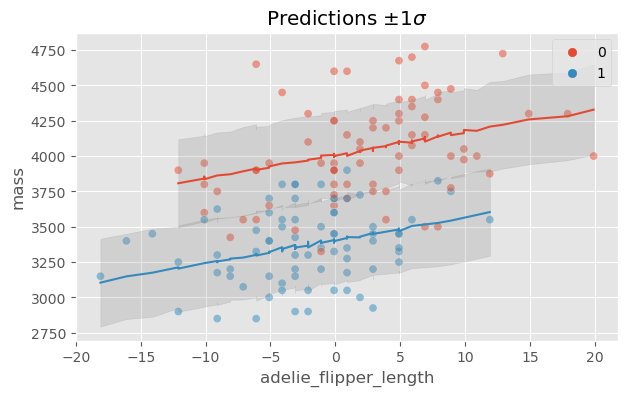

In [94]:
sns.scatterplot(
    x=adelie_flipper_length, y=adelie_mass_obs, hue=sex_obs, alpha=0.5)
plt.plot(male['flipper'], male['mass_mu'])
plt.plot(female['flipper'], female['mass_mu'])
plt.fill_between(
    male['flipper'], male['high'], male['low'], alpha=0.2, color='grey')
plt.fill_between(
    female['flipper'], female['high'], female['low'], alpha=0.2, color='grey')
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.title('Predictions $\pm 1 \sigma$ ')
plt.show()

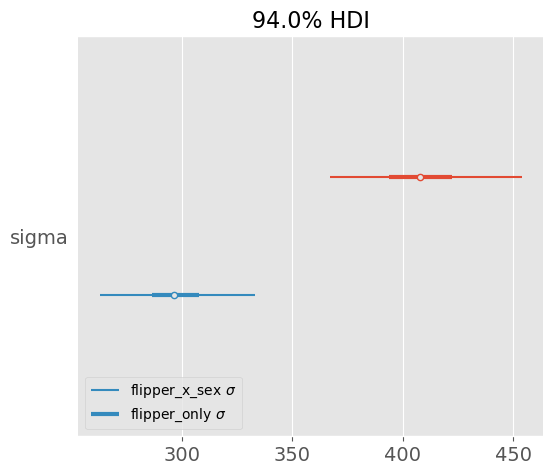

In [32]:
mcmc_multiple_az = az.from_pyro(mcmc)
mcmc_simple_az = az.from_pyro(mcmc_simple)

az.plot_forest([mcmc_simple_az, mcmc_multiple_az], var_names=['sigma'])
# manually specify to avoid confusion
plt.legend(['flipper_x_sex $\sigma$', 'flipper_only $\sigma$'])
plt.show()

### Counterfactuals

In [7]:
bill_length_obs = torch.from_numpy(penguins.loc[adelie_mask, 'bill_length_mm'].values)
bill_length_obs -= bill_length_obs.mean()

In [57]:
def linear_model_counterfactual(flipper_length, sex, bill_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 3000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 3000.))
    beta_2 = pyro.sample('beta_2', dist.Normal(0., 3000.))
    beta_3 = pyro.sample('beta_3', dist.Normal(0., 3000.))
    mu = pyro.deterministic(
        'mu', beta_0 + beta_1 * flipper_length + beta_2 * sex + beta_3 * bill_length)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

In [ ]:
pyro.render_model(
    linear_model_counterfactual, 
    model_args=(adelie_flipper_length, bill_length_obs, sex_obs, adelie_mass),
    render_distributions=True
    )

In [59]:
kernel = NUTS(linear_model_counterfactual, adapt_step_size=True)
mcmc = MCMC(kernel, num_samples=500, warmup_steps=300, num_chains=1)
mcmc.run(adelie_flipper_length, bill_length_obs, sex_obs, adelie_mass)
mcmc.summary()

Sample: 100%|██████████| 800/800 [01:08, 11.60it/s, step size=4.50e-01, acc. prob=0.913] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0   3978.38     41.39   3978.53   3900.43   4039.73    201.51      1.00
    beta_1     14.99      4.32     15.03      7.73     20.89    326.37      1.01
    beta_2     21.17     12.07     21.02      1.69     40.13    258.26      1.00
    beta_3   -541.23     64.61   -540.35   -646.93   -431.72    196.03      1.00
     sigma    295.87     16.45    294.49    269.92    323.25    452.90      1.00

Number of divergences: 0


In [61]:
mcmc_samples = mcmc.get_samples(num_samples=1000)

In [79]:
mean_flipper_length = penguins.loc[adelie_mask, 'flipper_length_mm'].mean()
counterfactual_flipper_lengths = torch.linspace(mean_flipper_length - 20, mean_flipper_length + 20, 21)
counterfactual_flipper_lengths -= counterfactual_flipper_lengths.mean()

sex_indicator = torch.zeros_like(counterfactual_flipper_lengths)
mean_bill_length = torch.ones_like(counterfactual_flipper_lengths) * bill_length_obs.mean()

In [80]:
counterfactual_samples = Predictive(
    linear_model_counterfactual,
    mcmc_samples)(counterfactual_flipper_lengths, sex_indicator, mean_bill_length, None)

mass_mu = counterfactual_samples['mass'].numpy().mean(axis=0)
mass_std = counterfactual_samples['mass'].numpy().std(axis=0)

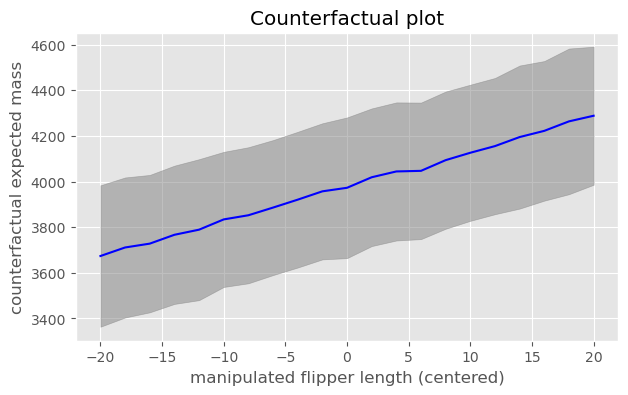

In [93]:
plt.plot(counterfactual_flipper_lengths, mass_mu, color='blue')
plt.fill_between(
    x=counterfactual_flipper_lengths , 
    y1=mass_mu + mass_std, 
    y2=mass_mu - mass_std,
    color='grey',
    alpha=0.5)
plt.ylabel('counterfactual expected mass')
plt.xlabel('manipulated flipper length (centered)')
plt.title('Counterfactual plot');

## Generalized Linear Models

### Logistic Regression

In [289]:
species_filter = penguins['species'].isin(['Adelie', 'Chinstrap'])

In [ ]:
species_filter = penguins['species'].isin(['Adelie', 'Chinstrap'])
bill_length_obs = torch.from_numpy(penguins.loc[species_filter, 'bill_length_mm'].values.reshape(-1, 1))
bill_length_obs = torch.tensor(bill_length_obs, dtype=torch.float)

species = pd.Categorical(penguins.loc[species_filter, 'species'])
species_codes = torch.from_numpy(species.codes).to(torch.float64)
species_codes = torch.tensor(species_codes, dtype=torch.float)

In [193]:
def logistic_model(bill_length, species=None):

    N, P = bill_length.shape

    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 10.).expand([P]))#.unsqueeze(-1)
    mu = beta_0 + torch.matmul(beta_1, bill_length.T) 
    theta = pyro.deterministic('theta', torch.sigmoid(mu))
    db = pyro.deterministic('db', -beta_0 / beta_1)

    with pyro.plate('plate'):
        y1 = pyro.sample('y1', dist.Bernoulli(theta), obs=species)

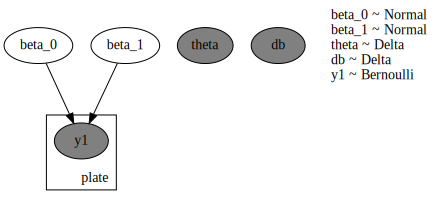

In [180]:
# we don't observe theta or db
pyro.render_model(
    logistic_model, 
    model_args=(bill_length_obs, species_codes),
    render_distributions=True)

### MCMC

In [181]:
kernel = NUTS(logistic_model, adapt_step_size=True)
mcmc_logistic = MCMC(kernel, num_samples=500, warmup_steps=300)
mcmc_logistic.run(bill_length=bill_length_obs, species=species_codes)
mcmc_logistic.summary()

Sample: 100%|██████████| 800/800 [00:11, 70.35it/s, step size=9.29e-02, acc. prob=0.857]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0    -33.38      4.12    -33.01    -41.20    -27.87     55.78      1.00
 beta_1[0]      0.75      0.10      0.75      0.61      0.91     55.19      1.00

Number of divergences: 0


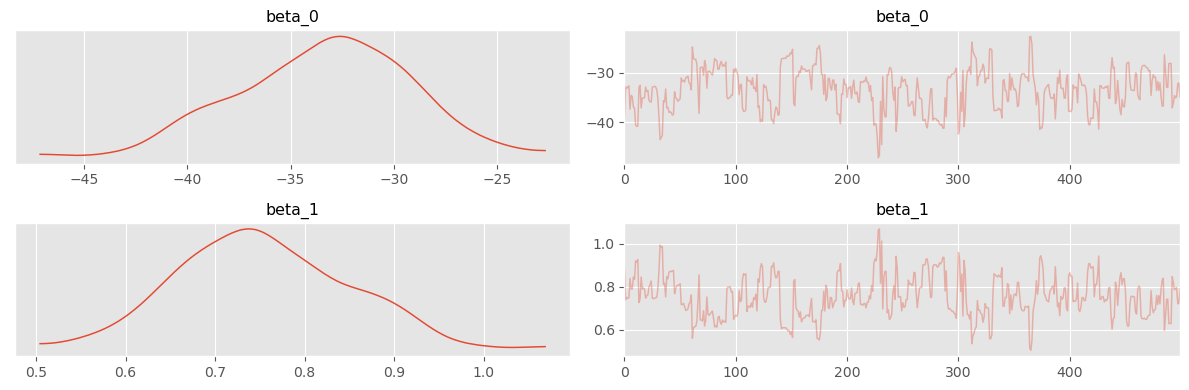

In [182]:
az.plot_trace(az.from_pyro(mcmc_logistic))
plt.tight_layout()

In [183]:
# latent variables
mcmc_samples = mcmc_logistic.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(logistic_model, mcmc_samples)
# posterior predictive
predictive_samples = predictive(bill_length_obs, None) 

In [184]:
prob_mu = predictive_samples['theta'].numpy().mean(axis=0).flatten()
prob_std = predictive_samples['theta'].numpy().std(axis=0).flatten()
db_mu = predictive_samples['db'].numpy().mean()
db_std = predictive_samples['db'].numpy().std()

predictions = pd.DataFrame({
    'bill_length': bill_length_obs.flatten(),
    'prob_mu': prob_mu,
    'prob_std': prob_std,
    'high': prob_mu + prob_std,
    'low': prob_mu - prob_std
})

predictions = predictions.sort_values(by=['bill_length'])

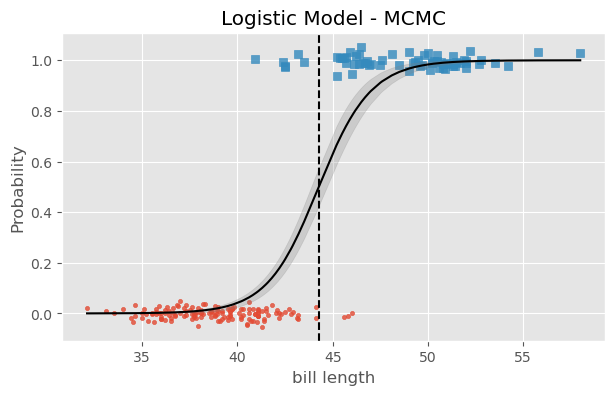

In [187]:
for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i) ## size
    x = bill_length_obs[_filter] ## x_obs
    y = np.random.normal(i, 0.02, size=_filter.sum()) ## small amount of noise (jitter)
    plt.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

plt.plot(predictions['bill_length'], predictions['prob_mu'], color='black')
plt.fill_between(
    predictions['bill_length'], predictions['high'], predictions['low'],
    alpha=0.25, color='grey')
plt.axvline(
    x=predictive_samples['db'].numpy().mean(), linestyle='--', color='black')
plt.xlabel('bill length')
plt.ylabel('Probability')
plt.title('Logistic Model - MCMC');

### SVI

In [194]:
def logistic_guide(bill_length, species=None):

    N, P = bill_length.shape
    
    beta_0_loc = pyro.param('beta_0_loc', torch.tensor(0.))
    beta_0_scale = pyro.param('beta_0_scale', torch.tensor(0.1), constraint=constraints.positive)
    beta_0 = pyro.sample('beta_0', dist.Normal(beta_0_loc, beta_0_scale))

    beta_1_loc = pyro.param('beta_1_loc', torch.tensor(0.1))
    beta_1_scale = pyro.param('beta_1_scale', torch.tensor(0.1), constraint=constraints.positive)
    beta_1 = pyro.sample('beta_1', dist.Normal(beta_1_loc, beta_1_scale).expand([P]))

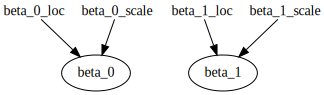

In [195]:
pyro.render_model(
    logistic_guide, 
    model_args=(bill_length_obs, species_codes), 
    render_params=True
    )

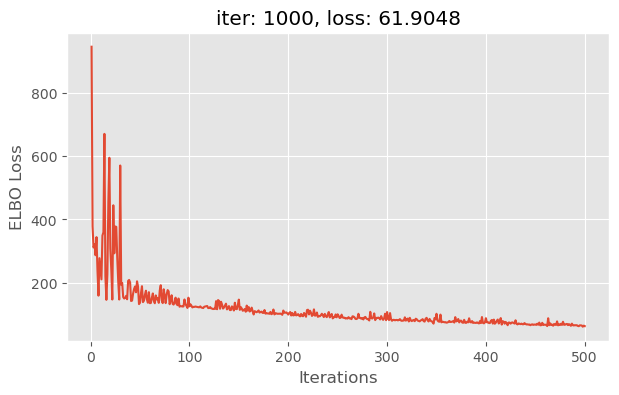

In [197]:
pyro.clear_param_store()

optim = Adam({"lr": 0.2})
svi = SVI(logistic_model, logistic_guide, optim, Trace_ELBO())

elbo_loss = []
for i in range(500):
    loss = svi.step(bill_length_obs, species_codes)
    elbo_loss.append(loss)

plt.plot(np.arange(1, 501), elbo_loss)
plt.ylabel('ELBO Loss')
plt.xlabel('Iterations')
plt.title(f'iter: 1000, loss: {elbo_loss[-1]:.4f}');

In [198]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

beta_0_loc tensor(-13.7759, requires_grad=True)
beta_0_scale tensor(0.1191, grad_fn=<AddBackward0>)
beta_1_loc tensor(0.3193, requires_grad=True)
beta_1_scale tensor(0.0044, grad_fn=<AddBackward0>)


In [199]:
predictive = Predictive(logistic_model, guide=logistic_guide, num_samples=1000)
posterior_svi_samples = predictive(bill_length_obs, None)

In [200]:
prob_mu = posterior_svi_samples['theta'].numpy().mean(axis=0).flatten()
prob_std = posterior_svi_samples['theta'].numpy().std(axis=0).flatten()

predictions = pd.DataFrame({
    'bill_length': bill_length_obs.flatten(),
    'prob_mu': prob_mu,
    'prob_std': prob_std,
    'high': prob_mu + prob_std,
    'low': prob_mu - prob_std
})

predictions = predictions.sort_values(by=['bill_length'])

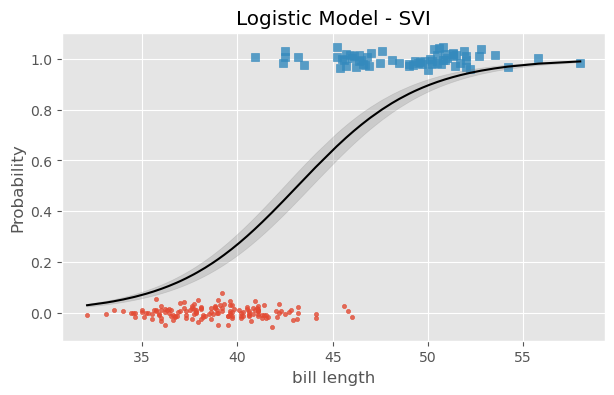

In [201]:
for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i) ## size
    x = bill_length_obs[_filter] ## x_obs
    y = np.random.normal(i, 0.02, size=_filter.sum()) ## add small amount of noise for plotting
    plt.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

plt.plot(predictions['bill_length'], predictions['prob_mu'], color='black')
plt.fill_between(
    predictions['bill_length'], predictions['high'], predictions['low'],
    alpha=0.25, color='grey')
# plt.axvline(
#     x=predictive_samples['db'].numpy().mean(), linestyle='--', color='black')
plt.xlabel('bill length')
plt.ylabel('Probability')
plt.title('Logistic Model - SVI');

### Code 3.24

Using body mass **and** flipper length as covariates

When creating a multidimensional distribution in pyro, there is the added functionality of `.to_event(1)`. This method implies that "these dimensions should be treated as a single event".
- see discussion [here](https://forum.pyro.ai/t/understanding-when-to-use-to-event-in-vae-tutorial/2380) 

In [97]:
X = penguins.loc[species_filter, ['bill_length_mm', 'body_mass_g']]

bill_length_mu = X['bill_length_mm'].mean()
bill_length_std = X['bill_length_mm'].std()
body_mass_g_mu = X['body_mass_g'].mean()
body_mass_g_std = X['body_mass_g'].std()

X['bill_length_mm'] = (X['bill_length_mm'] - bill_length_mu) / bill_length_std
X['body_mass_g'] = (X['body_mass_g'] - body_mass_g_mu) / body_mass_g_std
X = torch.from_numpy(X.values).to(torch.float)

intercept = torch.ones_like(X[:, 0][..., None])
X = torch.hstack((intercept, X))

species_codes = species_codes.to(torch.float)

In [89]:
def multiple_logistic_model(data_matrix, species=None):

    N, K = data_matrix.size()

    # w = pyro.sample('coef', dist.MultivariateNormal(
    #     loc=torch.ones(K), covariance_matrix=torch.eye(K)
    # ))

    w = pyro.sample('coef', dist.Normal(0., 10.).expand([K]))    
    mu = torch.matmul(w, data_matrix.T)
    theta = pyro.deterministic('theta', torch.sigmoid(mu))
    db = pyro.deterministic('db', -w[0] / w[2] - w[1] / w[2] * data_matrix[:, 1])
    
    with pyro.plate('output', N):
        y1 = pyro.sample('obs', dist.Bernoulli(logits=theta), obs=species)

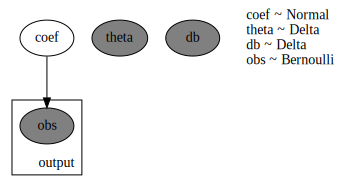

In [90]:
pyro.render_model(
    multiple_logistic_model, 
    model_args=(X, species_codes),
    render_distributions=True
    )

In [91]:
kernel = NUTS(model=multiple_logistic_model, adapt_step_size=True)
mcmc_mult_logistic = MCMC(kernel, num_samples=800, warmup_steps=500)
mcmc_mult_logistic.run(X, species_codes)

Sample: 100%|██████████| 1300/1300 [00:05, 222.11it/s, step size=2.76e-01, acc. prob=0.935]


In [92]:
mcmc_mult_logistic.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   coef[0]     -6.54      3.13     -6.00    -11.19     -1.35    154.09      1.00
   coef[1]     15.50      5.52     15.11      6.80     23.63    151.94      1.01
   coef[2]     -4.98      2.82     -4.58     -9.15     -0.30    203.16      1.00

Number of divergences: 0


In [93]:
mcmc_mult_samples = mcmc_mult_logistic.get_samples(num_samples=1000)
post_predictive = Predictive(multiple_logistic_model, mcmc_mult_samples)
predictive_samples = post_predictive(X, None)

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

obs: (1000, 214)
theta: (1000, 1, 214)
db: (1000, 1, 214)


In [ ]:
inf_data = az.from_pyro(
    mcmc_mult_logistic,
    posterior_predictive=mcmc_mult_samples
)

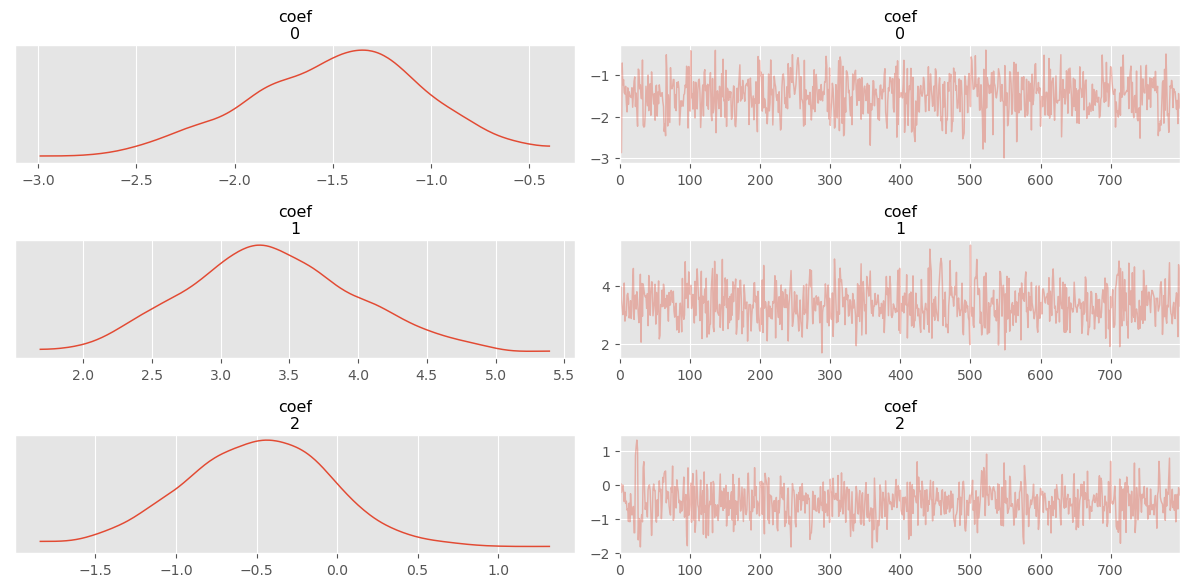

In [94]:
az.plot_trace(inf_data, compact=False, var_names=['coef'])
plt.tight_layout()
plt.show()

In [108]:
prob_mu = predictive_samples['theta'].mean(axis=0)[0]
prob_std = predictive_samples['theta'].std(axis=0)[0]
db_mu = predictive_samples['db'].mean(axis=0)[0]
db_std = predictive_samples['db'].std(axis=0)[0]

predictions = pd.DataFrame({
    'bill_length': X[:, 1].numpy(),
    'mass': X[:, 2].numpy(),
    'species': species_codes.numpy(),
    'prob_mu': prob_mu,
    'prob_std': prob_std,
    'high': prob_mu + prob_std,
    'low': prob_mu - prob_std,
    'db_mu': db_mu,
    'db_high': db_mu + db_std,
    'db_low': db_mu - db_std
})

predictions = predictions.sort_values(by=['bill_length', 'mass'])

(-10.0, 10.0)

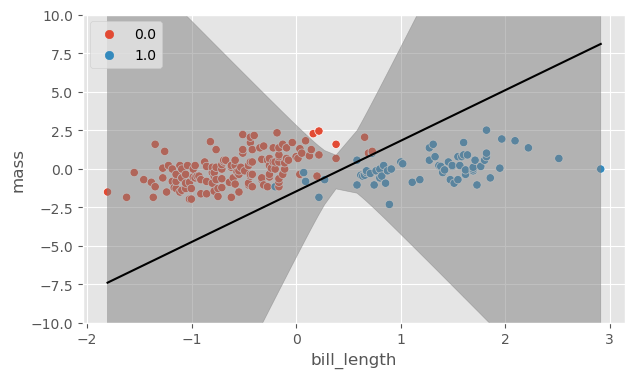

In [110]:
sns.scatterplot(data=predictions, x='bill_length', y='mass', hue='species')
sns.lineplot(data=predictions, x='bill_length', y='db_mu', color='black');
plt.fill_between(
    x=predictions['bill_length'], 
    y1=predictions['db_high'], 
    y2=predictions['db_low'],
    color='grey', alpha=0.5
    )
plt.ylim(bottom=-10, top=10)

In [ ]:
# not working
az.plot_separation(inf_data, y='obs')

### Interpreting log odds

In [168]:
counts = penguins['species'].value_counts()
adelie_count = counts['Adelie']
chinstrap_count = counts['Chinstrap']
adelie_probs = adelie_count / (adelie_count + chinstrap_count)

print(f'prior probability of adelie     = {adelie_probs:.4f}')
print(f'odds of adelie                  = {(adelie_probs / (1 - adelie_probs)):.4f}')
print(f'log odds (logit) of adelie      = {np.log(adelie_probs / (1 - adelie_probs)):.4f}')

prior probability of adelie     = 0.6822
odds of adelie                  = 2.1471
log odds (logit) of adelie      = 0.7641


In [181]:
beta_0 = inf_data['posterior']['coef'].to_numpy()[0][:, 0].mean()
beta_1 = inf_data['posterior']['coef'].to_numpy()[0][:, 1].mean()
beta_2 = inf_data['posterior']['coef'].to_numpy()[0][:, 2].mean()

bill_length = 0
val_1 = beta_0 + beta_1*bill_length + beta_2*0
val_2 = beta_0 + beta_1*(bill_length+0.5) + beta_2*0

val_1_probs = 1 / (1 + np.exp(-val_1))
val_2_probs = 1 / (1 + np.exp(-val_2))

print(f'''
increasing bill length by 0.5 stddev (while holding body mass constant) 
increases class probability from {val_1_probs:.2f} to {val_2_probs:.2f}
''')


increasing bill length by 0.5 stddev (while holding body mass constant) 
increases class probability from 0.19 to 0.55



## Picking priors in regression models

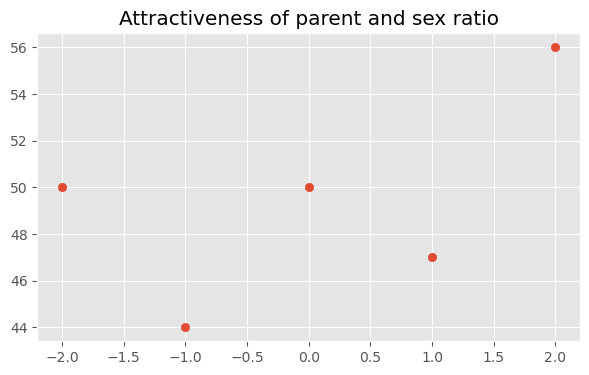

In [189]:
x = torch.arange(-2, 3, 1)
y = torch.tensor([50, 44, 50, 47, 56])

plt.scatter(x, y)
plt.title('Attractiveness of parent and sex ratio');

In [284]:
def model_uninformative_prior_sex_ratio(x, obs=None):

    sigma = pyro.sample('sigma', dist.Exponential(0.5))
    beta_0 = pyro.sample('beta_0', dist.Normal(50., 20.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 20.))

    mu = pyro.deterministic('mu', beta_0 + beta_1 * x)
    ratio = pyro.sample('ratio', dist.Normal(mu, sigma), obs=obs)

def model_informative_prior_sex_ratio(x, obs=None):

    sigma = pyro.sample('sigma', dist.Exponential(0.5))
    beta_0 = pyro.sample('beta_0', dist.Normal(50., 0.5))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 0.5))

    mu = pyro.deterministic('mu', beta_0 + beta_1 * x)
    ratio = pyro.sample('ratio', dist.Normal(mu, sigma), obs=obs)

In [285]:
sex_ratio_uninform_prior_mcmc = MCMC(NUTS(
    model_uninformative_prior_sex_ratio), num_samples=500, warmup_steps=300)
sex_ratio_uninform_prior_mcmc.run(x, y)

sex_ratio_inform_prior_mcmc = MCMC(NUTS(
    model_informative_prior_sex_ratio), num_samples=500, warmup_steps=300)
sex_ratio_inform_prior_mcmc.run(x, y)

Sample: 100%|██████████| 800/800 [00:02, 298.60it/s, step size=1.04e+00, acc. prob=0.879]


In [286]:
# uninformative prior
uninform_prior_predictive = Predictive(
    model_uninformative_prior_sex_ratio, 
    None, 
    num_samples=500)(x, None)

uninform_post_samples = sex_ratio_uninform_prior_mcmc.get_samples(500)

uninform_post_predictive = Predictive(
    model_uninformative_prior_sex_ratio, 
    posterior_samples=uninform_post_samples)(x, None)

# informative prior
inform_prior_predictive = Predictive(
    model_informative_prior_sex_ratio, 
    None, 
    num_samples=500)(x, None)

inform_post_samples = sex_ratio_inform_prior_mcmc.get_samples(500)

inform_post_predictive = Predictive(
    model_informative_prior_sex_ratio, 
    posterior_samples=inform_post_samples)(x, None)

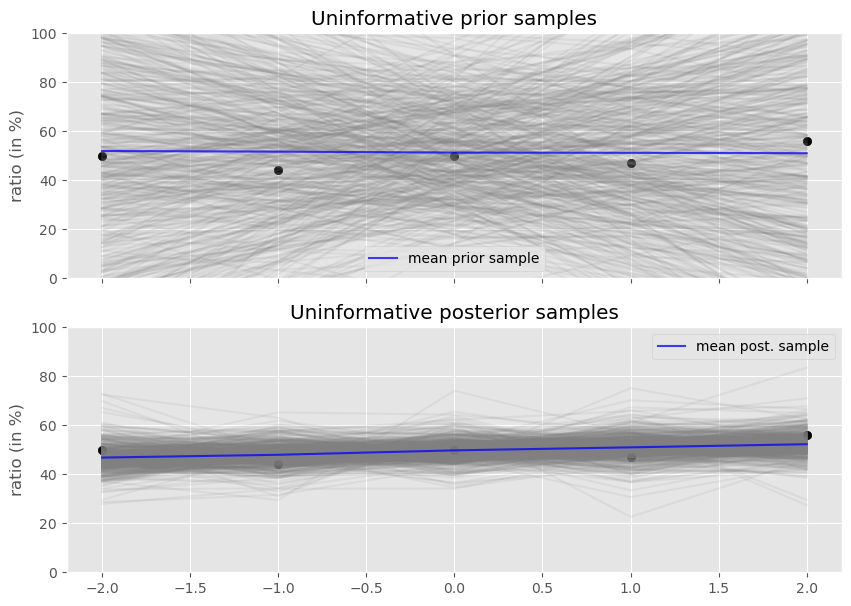

In [287]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 7))

ax[0].scatter(x, y, color='black')
ax[0].plot(x, uninform_prior_predictive['ratio'].T, color='grey', alpha=0.1)
ax[0].plot(x, uninform_prior_predictive['ratio'].mean(axis=0), color='blue', alpha=0.75, label='mean prior sample')
ax[0].set_ylabel('ratio (in %)')
ax[0].set_ylim(bottom=0, top=100)
ax[0].legend()
ax[0].set_title('Uninformative prior samples')

ax[1].scatter(x, y, color='black')
ax[1].plot(x, uninform_post_predictive['ratio'].T, color='grey', alpha=0.1)
ax[1].plot(x, uninform_post_predictive['ratio'].mean(axis=0), color='blue', alpha=0.75, label='mean post. sample')
ax[1].set_ylabel('ratio (in %)')
ax[1].set_ylim(bottom=0, top=100)
ax[1].legend()
ax[1].set_title('Uninformative posterior samples');

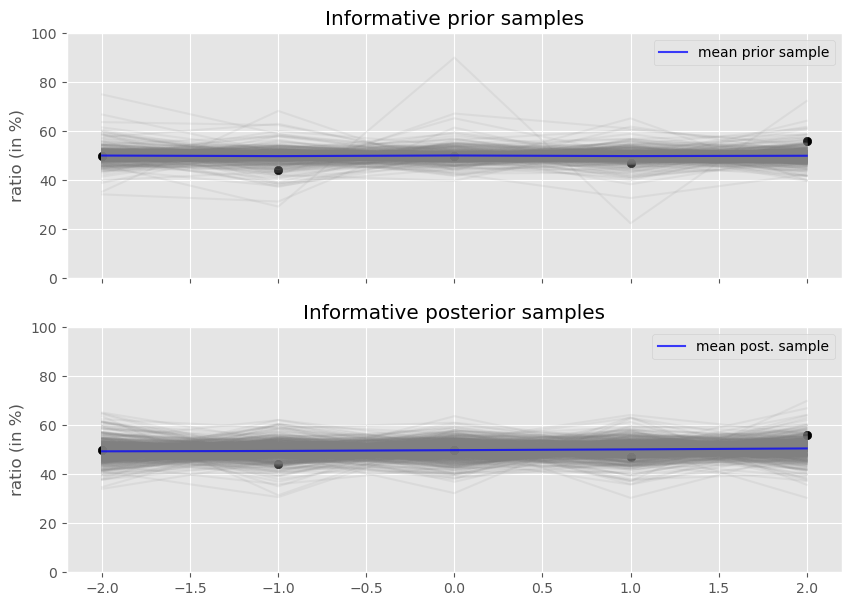

In [288]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 7))

ax[0].scatter(x, y, color='black')
ax[0].plot(x, inform_prior_predictive['ratio'].T, color='grey', alpha=0.1)
ax[0].plot(x, inform_prior_predictive['ratio'].mean(axis=0), color='blue', alpha=0.75, label='mean prior sample')
ax[0].set_ylabel('ratio (in %)')
ax[0].set_ylim(bottom=0, top=100)
ax[0].legend()
ax[0].set_title('Informative prior samples')

ax[1].scatter(x, y, color='black')
ax[1].plot(x, inform_post_predictive['ratio'].T, color='grey', alpha=0.1)
ax[1].plot(x, inform_post_predictive['ratio'].mean(axis=0), color='blue', alpha=0.75, label='mean post. sample')
ax[1].set_ylabel('ratio (in %)')
ax[1].set_ylim(bottom=0, top=100)
ax[1].legend()
ax[1].set_title('Informative posterior samples');